Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 152)]             0         
                                                                 
 dense (Dense)               (None, 16)                2432      
                                                                 
 activation (Activation)     (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 3)                 48        
                                                                 
 activation_1 (Activation)   (None, 3)                 0         
                                                                 
 dense_2 (Dense)             (None, 16)                48        
                                                                 
 activation_2 (Activation)   (None, 16)                0     

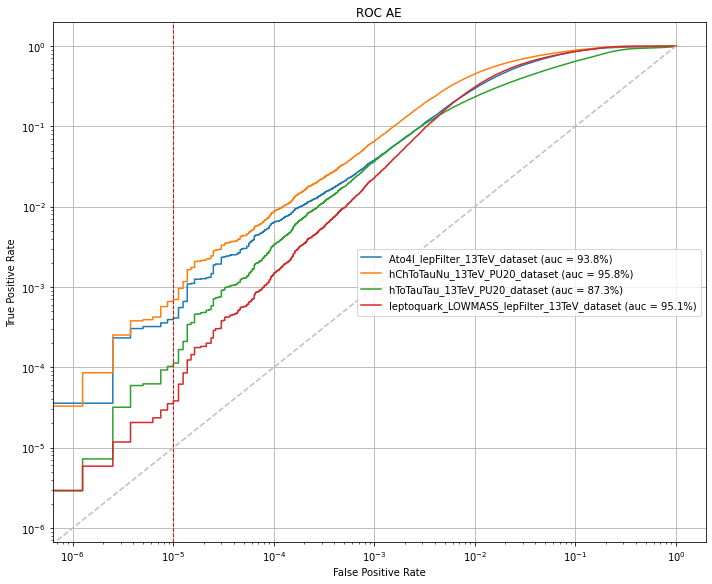


=========================Options=============================
-max_depth                  10000
-min_bytes                  0
-min_peak_bytes             0
-min_residual_bytes         0
-min_output_bytes           0
-min_micros                 0
-min_accelerator_micros     0
-min_cpu_micros             0
-min_params                 0
-min_float_ops              1
-min_occurrence             0
-step                       -1
-order_by                   float_ops
-account_type_regexes       .*
-start_name_regexes         .*
-trim_name_regexes          
-show_name_regexes          .*
-hide_name_regexes          
-account_displayed_op_only  true
-select                     float_ops
-output                     stdout:

==================Model Analysis Report======================

Doc:
op: The nodes are operation kernel type, such as MatMul, Conv2D. Graph nodes belonging to the same type are aggregated together.
flops: Number of float operations. Note: Please read the implementation for th

Incomplete shape.
Incomplete shape.
Incomplete shape.
Incomplete shape.
Incomplete shape.
Incomplete shape.
Incomplete shape.
Incomplete shape.
Incomplete shape.
Incomplete shape.
Incomplete shape.
Incomplete shape.
Incomplete shape.
Incomplete shape.
Incomplete shape.
Incomplete shape.
Incomplete shape.
Incomplete shape.
Incomplete shape.
Incomplete shape.
Incomplete shape.
Incomplete shape.
Incomplete shape.
Incomplete shape.
Incomplete shape.
Incomplete shape.
Incomplete shape.
Incomplete shape.
Incomplete shape.
Incomplete shape.
Incomplete shape.
Incomplete shape.
Incomplete shape.
Incomplete shape.
Incomplete shape.
Incomplete shape.
Incomplete shape.
Incomplete shape.
Incomplete shape.
Incomplete shape.
Incomplete shape.
Incomplete shape.


In [51]:
import numpy as np
import h5py
import math
import os
import pathlib
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Activation, Layer, ReLU, LeakyReLU
from tensorflow.keras import backend as K
import time
#from func import load_model, save_model
from func import mse_loss
from sklearn.metrics import roc_curve, auc


#flag#- tuleb sisendiks muuta funktsioonile

#def autoencoder(filename)

signal_in='./OH_signals/'
bkg_filename = './OH_signals/BKG_OH2_OH_dataset.h5'
X_train,X_test,X_val,signal_data,signal_labels=read_bkg_and_signals(bkg_filename,signal_in)

# add correct signal labels
data_labels  = ['Ato4l_lepFilter_13TeV_output',
                 'hChToTauNu_13TeV_PU20_output',
                 'hToTauTau_13TeV_PU20_output',
                 'leptoquark_LOWMASS_lepFilter_13TeV_output',
                 'background_for_training_output']


EPOCHS = 2
BATCH_SIZE = 1024
autoencoder=AE_setup_training(EPOCHS,BATCH_SIZE)


#Mudeli salvestamine
#Saab teha ehk save või nosave use existing model jne)
#flag#


#m_save='Yes'
#if m_save=='Yes':
#    model_name = 'DENSE_AE_OH4_model_flops_test'
#    model_directory = './models/'
#    print("saving")
#    save_model(model_directory+model_name, autoencoder)

#print('TF Profile: Total number of FLOPs =  {}'.format(get_flops(model_directory+model_name))



#flag#
#siia vaja siis eval teha. Tuleb selgeks teha kus.
#create np array that packs both bkg and signal predictions in flattened shape with OH vectors
#Siin tõenäoliselt backgroundi pole ju vaja?Või on?
AE_OH_results=[]
for i in range(5):
    if i==4:
        bkg_prediction = autoencoder.predict(X_test)
        AE_OH_results.append(np.array(bkg_prediction))
    else:
        signal_prediction = autoencoder.predict(signal_data[i])
        AE_OH_results.append(np.array(signal_prediction))
        
#ERALDAN signaalid OH vektoritena 4-se listina
signal_results = []
for i, label in enumerate(signal_labels):
    signal_results.append([label, signal_data[i], AE_OH_results[i]])
        
    #reshape the results and reverse OH vectors with argmax to single type of object
resh_type_results=[]
for i in range(5):
    data=AE_OH_results[i]#take list  with bkg and signals  flattened output
    data=predict_test=np.reshape(data,(len(data), 19,8))#reshape events by 19 objects
    id_oh=data[:,:,-5:]#take OH vector ids
    id_idmax=np.argmax(id_oh, axis=-1)#find the type
    id_idmax=np.reshape(id_idmax,(len(data),19,1))#reshape for concat
    event_wo_type=data[:,:,:3]#take events wo. type
    reshaped_data=np.concatenate([event_wo_type,id_idmax],axis=-1)#concat.
    resh_type_results.append(reshaped_data)#add to list
#
    #compute loss value (true, predicted)##1 väljund ja plot roc nr 3.
total_loss = []
total_loss.append(mse_loss(X_test, bkg_prediction.astype(np.float32)).numpy())
for i, signal_X in enumerate(signal_data):
    total_loss.append(mse_loss(signal_X, signal_results[i][2].astype(np.float32)).numpy())#
    
#Roc Curve
labels = np.concatenate([['Background'], np.array(signal_labels)])
target_background = np.zeros(total_loss[0].shape[0])
plt.figure(figsize=(10,8))
for i, label in enumerate(labels):
    if i == 0: continue # background events
    trueVal = np.concatenate((np.ones(total_loss[i].shape[0]), target_background)) # anomaly=1, bkg=0
    predVal_loss = np.concatenate((total_loss[i], total_loss[0]))
    fpr_loss, tpr_loss, threshold_loss = roc_curve(trueVal, predVal_loss)
    auc_loss = auc(fpr_loss, tpr_loss)
    plt.plot(fpr_loss, tpr_loss, "-", label='%s (auc = %.1f%%)'%(label,auc_loss*100.), linewidth=1.5)
    plt.semilogx()
    plt.semilogy()
    plt.ylabel("True Positive Rate")
    plt.xlabel("False Positive Rate")
    plt.legend(loc='center right')
    plt.grid(True)
    plt.tight_layout()
plt.plot(np.linspace(0, 1),np.linspace(0, 1), '--', color='0.75')
plt.axvline(0.00001, color='red', linestyle='dashed', linewidth=1) # threshold value for measuring anomaly detection efficiency
plt.title("ROC AE")
plt.show()


#print(get_flops('flops_test2.h5'))

In [1]:
def read_bkg_and_signals(bkg_filename,signal_in):
    #Outputs training,test,validation and signal_data data
    #From assigned source/path
    # add correct path to signal files
    signals_file = [signal_in+'Ato4l_lepFilter_13TeV_input_OH_dataset.h5',
                signal_in+'hChToTauNu_13TeV_PU20_input_OH_dataset.h5',
                signal_in+'hToTauTau_13TeV_PU20_input_OH_dataset.h5',
                signal_in+'leptoquark_LOWMASS_lepFilter_13TeV_input_OH_dataset.h5'] 
    # add correct signal labels
    signal_labels = ['Ato4l_lepFilter_13TeV_dataset',
                     'hChToTauNu_13TeV_PU20_dataset',
                     'hToTauTau_13TeV_PU20_dataset',
                     'leptoquark_LOWMASS_lepFilter_13TeV_dataset']    
    with h5py.File(bkg_filename, 'r') as file:
        X_train = np.array(file['X_train'])
        X_test = np.array(file['X_test'])
        X_val = np.array(file['X_val'])
    signal_data = []
    for i, label in enumerate(signal_labels):
        with h5py.File(signals_file[i], 'r') as file:
            test_data = np.array(file['Data'])
        signal_data.append(test_data)
    
    return X_train,X_test,X_val,signal_data,signal_labels

In [50]:
def AE_setup_training(EPOCHS,BATCH_SIZE):
    #Autoencoder(AE) model setup
    input_shape = 152
    latent_dimension = 3
    num_nodes=[16,8]
    
    #encoder
    inputArray = Input(shape=(input_shape))
    x = Dense(num_nodes[0], use_bias=False)(inputArray)
    x = Activation('relu')(x)
    x = Dense(latent_dimension, use_bias=False)(x)
    encoder = Activation('relu')(x)
    
    #decoder
    x = Dense(num_nodes[0], use_bias=False)(encoder)
    x = Activation('relu')(x)
    
    decoder = Dense(input_shape)(x)
    #Create AE
    autoencoder = Model(inputs = inputArray, outputs=decoder)
    autoencoder.summary()
    
    #Compile AE
    autoencoder.compile(optimizer = keras.optimizers.Adam(), loss='mse')
    autoencoder.save('flops_test2.h5')

   
    
    #Treenimine
    #EPOCHS = 10
    #BATCH_SIZE = 1024
    history = autoencoder.fit(X_train, X_train, epochs = EPOCHS, batch_size = BATCH_SIZE,
                  validation_data=(X_val, X_val))
    
    return autoencoder

In [43]:
def get_flops(path_for_flops):
    session = tf.compat.v1.Session()
    graph = tf.compat.v1.get_default_graph()

    with graph.as_default():
        with session.as_default():
            model = tf.keras.models.load_model(path_for_flops)
            
            run_meta = tf.compat.v1.RunMetadata()
            opts = tf.compat.v1.profiler.ProfileOptionBuilder.float_operation()

            # Optional: save printed results to file
            # flops_log_path = os.path.join(tempfile.gettempdir(), 'tf_flops_log.txt')
            # opts['output'] = 'file:outfile={}'.format(flops_log_path)

            # We use the Keras session graph in the call to the profiler.
            flops = tf.compat.v1.profiler.profile(graph=graph,
                                                  run_meta=run_meta, cmd='op', options=opts)

    tf.compat.v1.reset_default_graph()

    return flops.total_float_ops


#print('TF Profile: Total number of FLOPs =  {}'.format(get_flops()))
# Profile:
# node name | # float_ops
# Mul                      2.02k float_ops (100.00%, 49.95%)
# Add                      2.02k float_ops (50.05%, 49.93%)
# Sub                          5 float_ops (0.12%, 0.12%)

In [13]:
from keras.models import model_from_json
def load_model(model_name, custom_objects=None):
    name = model_name + '.json'
    json_file = open(name, 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    model = model_from_json(loaded_model_json, custom_objects=custom_objects)
    model.load_weights(model_name + '.h5')
    return model

def save_model(model_save_name, model):
    with open(model_save_name + '.json', 'w') as json_file:
        json_file.write(model.to_json())
    model.save_weights(model_save_name + '.h5')